In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torch import nn

In [2]:
from utils import train_loop

In [3]:
import os
from pathlib import Path


os.chdir(Path(os.getcwd()).parent)

In [4]:
RANDOM_STATE = 42

In [5]:
rcParams['figure.figsize'] = (13, 7)

In [6]:
import torch
from torch import nn
from slovnet.model.emb import NavecEmbedding
from navec import Navec


class LSTMLabelEndClassifierNavec(nn.Module):
    def __init__(
            self,
            hidden_size: int,
            num_layers=1,
            embedding_dim=256,
            dropout_e=0,
            dropout_p=0,
            bidirectional=False
            ):
        super().__init__()

        self.bidirectional = bidirectional

        navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
        NAVEC_EMB_DIM = 300
        self.embedding = nn.Sequential(
            NavecEmbedding(navec),
            nn.Dropout(dropout_e),
            nn.Linear(NAVEC_EMB_DIM, embedding_dim),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )

        proj_hidden_size = hidden_size * 2 if self.bidirectional else hidden_size
        self.project = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(proj_hidden_size, 1)
        )
        self.softmax = nn.Softmax(1)

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        output, _ = (self.lstm(self.embedding(batch)))

        return self.softmax(self.project(output)).flatten(1)


In [7]:
import json

from nltk.stem import PorterStemmer, SnowballStemmer

from document_dataset import LabeledDocumentDataset, DocumentDataset



with open('data/word_idx_snowball.json') as f:
    word_idx = json.load(f)


navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
stemmer = lambda x: x.lower()
with open('data/first_label_train.json') as first_train, open('data/first_label_test.json') as first_test:
    first_train_dataset = LabeledDocumentDataset(json.load(first_train), navec.vocab, stemmer=stemmer, max_document_length=800, add_end_token=False)
    first_test_dataset = LabeledDocumentDataset(json.load(first_test), navec.vocab, stemmer=stemmer, max_document_length=800, add_end_token=False)

In [8]:
from torch.utils.data import DataLoader


train_dataloader = DataLoader(first_train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(first_test_dataset, batch_size=500)

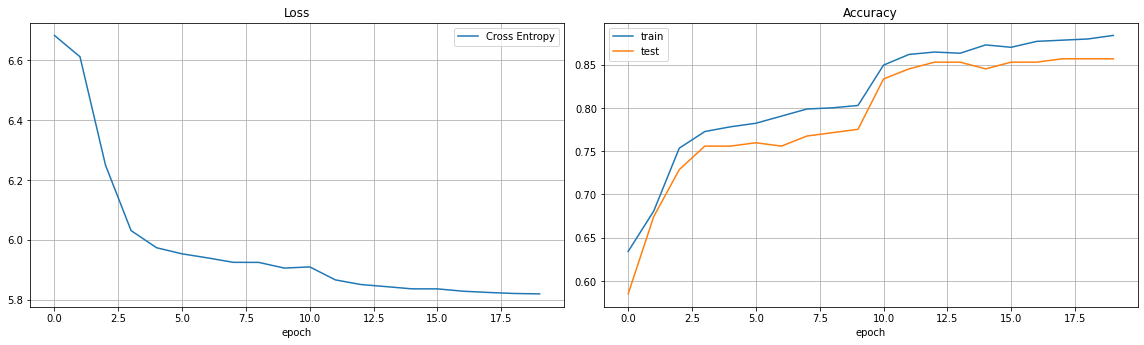

In [10]:
first_label_start_bidir_clf = LSTMLabelEndClassifierNavec(
    hidden_size=16,
    embedding_dim=32,
    dropout_e=0.3,
    dropout_p=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=first_label_start_bidir_clf,
    train_on_start=True
)

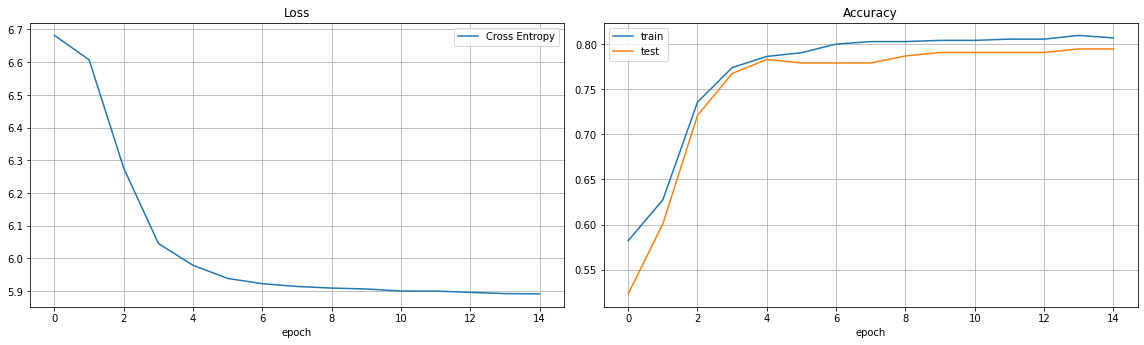

KeyboardInterrupt: 

In [11]:
first_label_start_bidir_clf = LSTMLabelEndClassifierNavec(
    hidden_size=16,
    embedding_dim=16,
    dropout_e=0.3,
    dropout_p=0.1,
    bidirectional=True,
)

train_loop(
    n_epoch=20,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    lr=0.002,
    clf=first_label_start_bidir_clf,
    train_on_start=True
)